# IN-DEPTH ANALYSIS(MACHINE LEARNING)

In this part of the Capstone Project, we will train the dataset with suitable Machine Learning Models on train set and predict the target variable i.e Sale Price for Test set.  

In [1]:
#Necassary Imports and reading data.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")


In [2]:
from sklearn.linear_model import Lasso

In [3]:
train=pd.read_csv('train.csv')



## Preprocessing and Feature Engineering steps:
    We would clean the data and create new variables as follows.
1. Creating list of categories and numeric columns.
2. Creation of new variable 'newsqavr'.
3. Creating new variables out of numeric variables that reflect absence or presence of zero.
4. Filling NaN and zero with interpolation
5. Categorical Nan's filled with 'Absent'
6. All categorical variables have been converted into numeric values that represent mean Saleprice of each label.

In [4]:
# Creating list of categories and numeric columns
# Creation of new variable 'newsqvar'
from pandas.api.types import is_numeric_dtype
numcollist=[col for col in train.drop('Id', axis=1).columns if is_numeric_dtype(train[col]) ]
ordlist=[col for col in numcollist if train[col].nunique() < 16 ]
ordlist.append('YearBuilt')
ordlist.append('YearRemodAdd')
ordlist.append('GarageYrBlt')
for col in ordlist:
    numcollist.remove(col)
categlist=[col for col in train.drop('Id', axis=1).columns if not is_numeric_dtype(train[col])]

categlist=categlist+ ordlist


train['newsqvar']=train['TotalBsmtSF']+train['1stFlrSF']+train['GrLivArea']
droplist=['TotalBsmtSF','1stFlrSF','GrLivArea']
train=train.drop(droplist, axis=1)
for col in droplist:
    numcollist.remove(col)
numcollist.append('newsqvar')


In [5]:
# Creating new variables out of numeric variables that reflect absence or presence of zero.
for col in numcollist:
    if 0 in train[col].values:
        #print(col)
        train['zero'+col]=np.where(train[col]==0,1,0)
        categlist.append('zero'+col)
# Nan Imputation
train[numcollist]=train[numcollist].replace(0, np.nan).interpolate(kind='linear',limit_direction='both')
train[categlist]=train[categlist].fillna('Absent')

In [6]:
# Function for labelling categorical variables with numeric values.

def train_category_conversion(col):
    a=train.groupby(col)['SalePrice'].mean()
    a=round((a/10000),2)
    index=a.index.values.tolist()
    weight=a.values.tolist()
    zipped=list(zip(index,weight))
    dict1=dict(zipped)
    train[col]=train[col].map(dict1)

# Function for labelling categorical variables with numeric values for test data.
def test_category_conversion(col):
    a=test.groupby(col)['SalePrice'].mean()
    a=round((a/10000),2)
    index=a.index.values.tolist()
    weight=a.values.tolist()
    zipped=list(zip(index,weight))
    dict1=dict(zipped)
    test[col]=test[col].map(dict1)


# Perform numeric labelling of categorical variables for train data    
for col in categlist:
    train_category_conversion(col)


## Lasso regularisation for feature selection.
Now we have a train set which is cleaned and transformed. We need to select few relevant features. This helps in reducing cost. For this we will apply Lasso Regularisation.

In [7]:
# We create Lasso Regression  object with tuned alpha and fit the data. The data is converted to its logarithmic equivalent.
from sklearn.linear_model import Lasso
X=np.log(train.drop(['SalePrice', 'Id'], axis=1))
y=np.log(train['SalePrice'])
lasso=Lasso(alpha=.001 , random_state=40)
lasso.fit(X,y)



Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=40,
      selection='cyclic', tol=0.0001, warm_start=False)

In [8]:
# Now we create a dataframe of coefficients and view the top 20 of them
lasso_features=pd.DataFrame({'features': X.columns, 'coefficients': lasso.coef_}).sort_values(by='coefficients', ascending=False)
lasso_features.head(37)



,features,coefficients
76,newsqvar,0.377496
16,OverallQual,0.287977
11,Neighborhood,0.178389
46,HalfBath,0.124948
39,CentralAir,0.114512
51,Functional,0.107008
19,YearRemodAdd,0.106771
31,BsmtExposure,0.085539
1,MSZoning,0.084282
50,TotRmsAbvGrd,0.082489


In [9]:
# We create a list of features whise coefficients are non zero.
featurecols=lasso_features[lasso_features['coefficients']!=0]['features'].values.tolist()
len(featurecols)

37

Text(0.5, 1.0, 'Lasso Features- Highest coefficients')

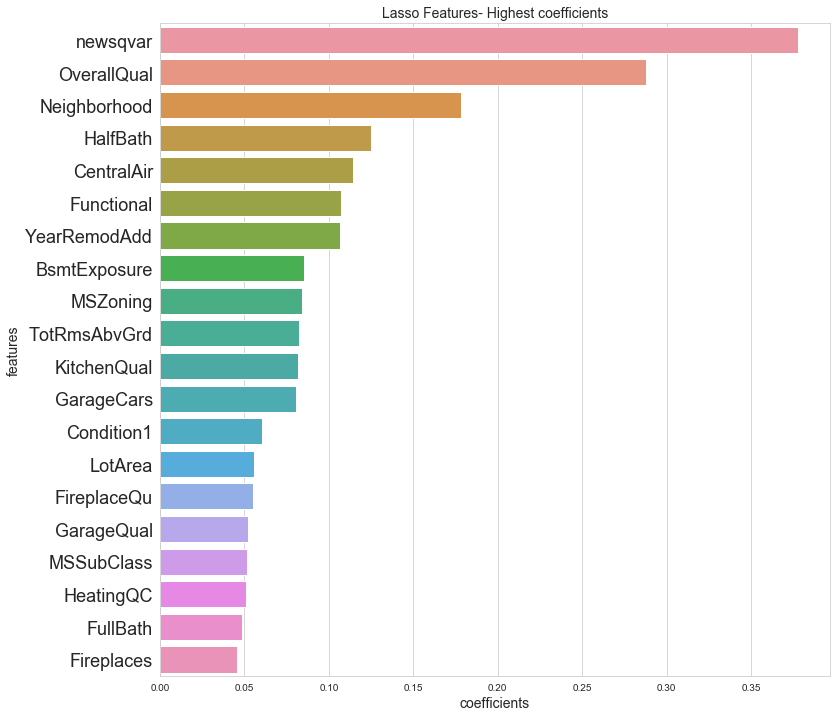

In [10]:
plt.figure(figsize=(12,12))
ax=sns.barplot(x='coefficients',y='features', data=lasso_features.head(20) )
ax.set_xlabel('coefficients', fontsize=14)
ax.set_ylabel('features', fontsize=14)
ax.tick_params(axis="y", labelsize=18)
ax.set_title('Lasso Features- Highest coefficients', fontsize=14)


## Finding features which are statistically significant.
We have 37 features which are suitable for the model. However we can further reduce this number by selecting the features which are statistically significant. This helps in reducing costs and building a model that would be accurate most of the time when applied on unseen data. We can import Ols from stats model which gives us the p values of features.

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [12]:
for col  in featurecols:
    print(col,' + ', end='')

newsqvar  + OverallQual  + Neighborhood  + HalfBath  + CentralAir  + Functional  + YearRemodAdd  + BsmtExposure  + MSZoning  + TotRmsAbvGrd  + KitchenQual  + GarageCars  + Condition1  + LotArea  + FireplaceQu  + GarageQual  + MSSubClass  + HeatingQC  + FullBath  + Fireplaces  + GarageCond  + SaleCondition  + YearBuilt  + BsmtQual  + WoodDeckSF  + Exterior1st  + GarageYrBlt  + MasVnrArea  + 2ndFlrSF  + GarageFinish  + EnclosedPorch  + BsmtFinSF1  + BedroomAbvGr  + MiscVal  + ScreenPorch  + LotFrontage  + BsmtUnfSF  + 

Note: There are certain types of column names that are not accepted by ols model. Hence only for the purpose of this model, I am creating a seperate dataframe with some columns renamed.

In [13]:
#Creating a dataframe olslogtrain
logtrain=np.log(train)
olslogtrain=logtrain
olslogtrain.rename(columns={"1stFlrSF": "FirstFlrSF", "2ndFlrSF": "SecondFlrSf","3SsnPorch": "ThreeSsnPorch" }, inplace=True)

In [14]:
# Fitting ols model to data
olsmodel1=ols('SalePrice ~  MSZoning  + LotArea  + Neighborhood  + Condition1  + OverallQual    + YearRemodAdd       + BsmtExposure    + BsmtUnfSF  + HeatingQC  + CentralAir    + FullBath  + HalfBath  + BedroomAbvGr  + KitchenQual  + TotRmsAbvGrd  + Functional      + GarageCars    + WoodDeckSF    + SaleCondition  + newsqvar ',olslogtrain).fit()
print(olsmodel1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     584.9
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        00:25:23   Log-Likelihood:                 883.01
No. Observations:                1460   AIC:                            -1724.
Df Residuals:                    1439   BIC:                            -1613.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4498      0.271      5.346

__Observations:__
1. Features that have p values greater than or equal to .05 have been seperated.
2. All remaining features above have p_values lesser than .05 and hence are statisticaly significant.
3. R^2 is 89% which shows how much variance in data is explained by model. The higher this value, the better predictor the model is.
4. P value of F-statistic is 0, which shows that the fitted model is statistically significant.

In [15]:
# The list of features are reduced on the basis of above findings
dropcols=['MSSubClass','MasVnrArea' , 'LotFrontage','YearBuilt','Exterior1st','BsmtQual','BsmtFinSF1','2ndFlrSF' ,'Fireplaces','FireplaceQu','GarageYrBlt','GarageFinish','GarageQual','GarageCond' ,'EnclosedPorch' ,'ScreenPorch' ,'MiscVal']  
for col in dropcols:
    featurecols.remove(col)


Text(0.5, 1.0, 'Features - statistically significant')

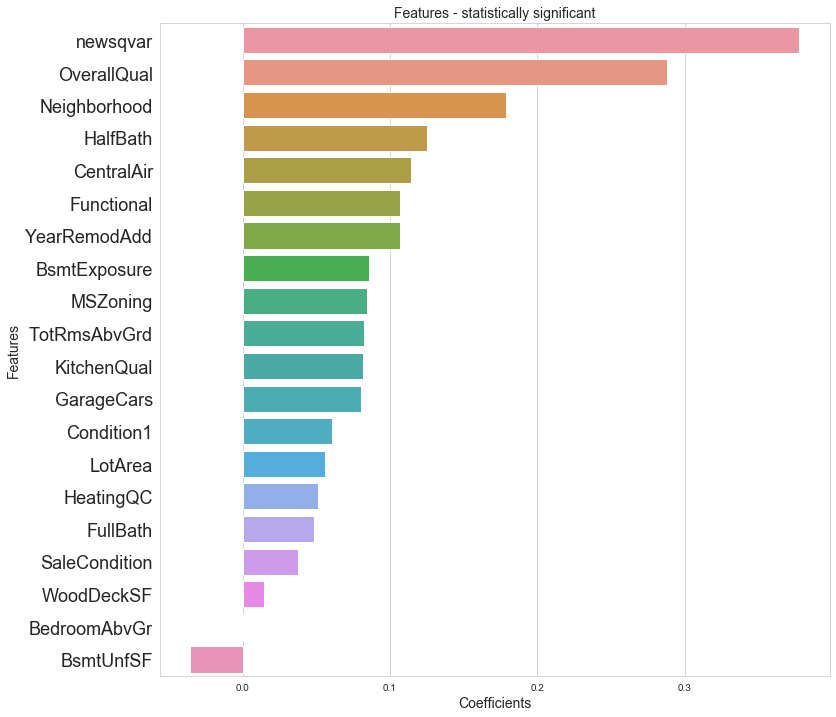

In [16]:
# Adjusting Lasso_features dataframe to view only statistically significant features.
lasso_features=lasso_features[lasso_features['coefficients']!=0]
lasso_features=lasso_features.set_index('features')
lasso_features=lasso_features.drop(dropcols, axis=0)
lasso_features=lasso_features.reset_index()
# Let's plot the top 20 statistically significant features as per their coefficients.
plt.figure(figsize=(12,12))
ax=sns.barplot(x='coefficients',y='features', data=lasso_features.head(20) )
ax.set_xlabel('Coefficients', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.tick_params(axis="y", labelsize=18)
ax.set_title('Features - statistically significant', fontsize=14)


In [17]:
featurecols

['newsqvar',
 'OverallQual',
 'Neighborhood',
 'HalfBath',
 'CentralAir',
 'Functional',
 'YearRemodAdd',
 'BsmtExposure',
 'MSZoning',
 'TotRmsAbvGrd',
 'KitchenQual',
 'GarageCars',
 'Condition1',
 'LotArea',
 'HeatingQC',
 'FullBath',
 'SaleCondition',
 'WoodDeckSF',
 'BedroomAbvGr',
 'BsmtUnfSF']

## Residual Plot for identifying outliers
In residuals plots, for Linear Regression, there are following underlying assumptions :
    1. The residuals should not have a pattern.
    2. The residuals should have a constant variance around the mean i.e 0.
This will help us to identify outliers

Text(0.5, 1.0, 'Residual vs Fitted plot')

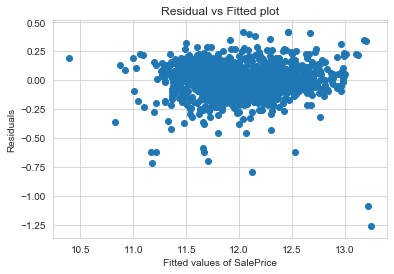

In [18]:
# Create Linear Regression object and fit on data.

from sklearn.preprocessing import FunctionTransformer
logfunc=FunctionTransformer(np.log, inverse_func=np.exp)
logX=logfunc.fit(train[featurecols].values)
logy=logfunc.fit(train['SalePrice'].values)
X=logX.transform(train[featurecols].values)
y=logy.transform(train['SalePrice'].values)


from sklearn.linear_model import LinearRegression

lm=LinearRegression()
lm.fit(X,y)

# Residual Plot
prediction=lm.predict(X)
residual=y-prediction
plt.scatter(prediction, residual)
plt.xlabel('Fitted values of SalePrice')
plt.ylabel('Residuals')
plt.title('Residual vs Fitted plot')


From the plot above, we can identify the residual points above .25 and below -.25 as outliers. The same standard will be applied to test data.

In [19]:
# Identifying outliers.  
train['Residuals']=residual
train['Prediction']=prediction

outliers=train[(train['Residuals']>.25)|(train['Residuals']<-.25)].index.values.tolist()

train_lm=train.drop(outliers, axis=0)
train=train.drop(['Residuals','Prediction'], axis=1)

## Creating X (Features) and y (target variable) 

We need to set the feature and target variable so that models can be trained on them.

In [21]:
# Creating a log object and transforming Features and target variable

logfunc=FunctionTransformer(np.log, inverse_func=np.exp)
logX_lm=logfunc.fit(train_lm[featurecols].values)
logy_lm=logfunc.fit(train_lm['SalePrice'].values)
X_train_lm=logX_lm.transform(train_lm[featurecols].values)
y_train_lm=logy_lm.transform(train_lm['SalePrice'].values)

In [22]:
# with dropped outliers
logX_netrf=logfunc.fit(train.drop(outliers).drop(['SalePrice','Id'], axis=1).values)
logy_netrf=logfunc.fit(train.drop(outliers)['SalePrice'].values)
X_train_netrf=logX_netrf.transform(train.drop(outliers).drop(['SalePrice','Id'], axis=1).values)
y_train_netrf=logy_netrf.transform(train.drop(outliers)['SalePrice'].values)


### TEST DATA

In [23]:
#Reading Test data and merging it with sample_submission 
test=pd.read_csv('test.csv')
df2=pd.read_csv('sample_submission.csv')
test=pd.merge(test,df2, on='Id')


In [24]:
# Creating New variable'newsqvar' and amending the dataframe
test['newsqvar']=test['TotalBsmtSF']+test['1stFlrSF']+test['GrLivArea']
droplist=['TotalBsmtSF','1stFlrSF','GrLivArea']
test=test.drop(droplist, axis=1)

In [25]:
# Creating new variables out of numeric variables that reflect absence or presence of zero.
for col in numcollist:
    if 0 in test[col].values:
        test['zero'+col]=np.where(test[col]==0,1,0)


In [26]:
# Nan Imputation 
test[numcollist]=test[numcollist].replace(0, np.nan).interpolate(kind='linear',limit_direction='both')
test[categlist]=test[categlist].fillna('Absent')


In [27]:
# Perform numeric labelling of categorical variables for test data

for col in categlist:
    test_category_conversion(col)

In [28]:
# Identifying and deleting outliers for Linear Regression
X=logX.transform(test[featurecols].values)
y=logy.transform(test['SalePrice'].values)

prediction=lm.predict(X)
residual=y-prediction
test['Residuals']=residual
test['Prediction']=prediction

outliers=test[(test['Residuals']>.25)|(test['Residuals']<-.25)].index.values.tolist()

test_lm=test.drop(outliers, axis=0)
test=test.drop(['Residuals','Prediction'], axis=1)

## Creating X (Features) and y (target variable)  for test set.
We transform the Test data to its logarithmic equivalent using the log transformation object created. Before this step the outliers need to be taken care of. For identifying outliers this we have used the same criteria as we used for train data.

In [29]:
# Create features and target set from test data
X_test_lm=logX_lm.transform(test_lm[featurecols].values)
y_test_lm=logy_lm.transform(test_lm['SalePrice'].values)

In [30]:
# with dropped outliers

X_test_netrf=logX_netrf.transform(test.drop(outliers).drop(['SalePrice','Id'], axis=1).values)
y_test_netrf=logy_netrf.transform(test.drop(outliers)['SalePrice'].values)

# MODELS

## LINEAR REGRESSION MODEL


Let's create a Linear Regression Object and fit to train data.
The score for evaluating performance is Root Mean Square Error between log of Sale Price and log of Predictions.
We will use 5 fold cross validation on train set.

In [31]:
# Score function parameter
from sklearn.metrics import mean_squared_error, make_scorer
mean_sq_err=make_scorer(mean_squared_error)

In [32]:
# Create and fit Linear Regression object and compute cross validated score
from sklearn.model_selection import cross_val_score
lm1=LinearRegression()
lm1.fit(X_train_lm,y_train_lm)
cv_results=cross_val_score(lm1, X_train_lm, y_train_lm, scoring=mean_sq_err, cv=5)
print('The cross validated RMSE of Linear Regression Model- lm1, on train set is: ',round(np.sqrt(np.mean(cv_results)),3))

The cross validated RMSE of Linear Regression Model- lm1, on train set is:  0.096


In [55]:
prediction=lm1.predict(X_train_lm)
print('The RMSE i.e root mean squared error on Train set is : ', round(np.sqrt(mean_squared_error(y_train_lm, prediction)),3))
prediction=lm1.predict(X_test_lm)
print('The RMSE i.e root mean squared error on Test Set is: ', round(np.sqrt(mean_squared_error(y_test_lm, prediction)),3))

The RMSE i.e root mean squared error on Train set is :  0.094
The RMSE i.e root mean squared error on Test Set is:  0.12


## RIDGE REGRESSION MODEL

Let's create a Ridge Regression Object and fit to train data. The score for evaluating performance is Root Mean Square Error between log of Sale Price and log of Predictions. First we will use Grid Search cross validation on train set in order to tune alpha.



In [34]:
# We perform Grid serach cv for hyperparameter tuning
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

param_grid={'alpha':[0,.1,.3,.5,1,10,50]}
ridg_cv=GridSearchCV(Ridge(),param_grid,scoring=mean_sq_err, cv=5 )
ridg_cv.fit(X_train_lm, y_train_lm)

print(' Optimum value of alpha for Ridge Regression Model is: ' , ridg_cv.best_params_)
print(' The cross validated RMSE for Ridge Regression Model, on train set, using optimum value for alpha is :', np.sqrt(ridg_cv.best_score_).round(3))

 Optimum value of alpha for Ridge Regression Model is:  {'alpha': 50}
 The cross validated RMSE for Ridge Regression Model, on train set, using optimum value for alpha is : 0.112


In [35]:
# We create Ridge Regression object using optimum value for alpha and fit on train set.

ridg=Ridge(alpha =50)
ridg.fit(X_train_lm, y_train_lm)

prediction=ridg.predict(X_train_lm)
print('The RMSE for Ridge Regression Model on train set is :  ', round(np.sqrt(mean_squared_error(y_train_lm, prediction)),3))

prediction=ridg.predict(X_test_lm)
print('The RMSE for Ridge Regression Model on test set is :  ', round(np.sqrt(mean_squared_error(y_test_lm, prediction)),3))


The RMSE for Ridge Regression Model on train set is :   0.108
The RMSE for Ridge Regression Model on test set is :   0.089


## SEARCH VECTOR MACHINE -REGRESSION

In [36]:
# Let's apply SVM to the dataset. Here we use default parameters.

In [37]:
from sklearn.svm import SVR
svm_reg=SVR()

In [38]:
svm_reg.get_params

<bound method BaseEstimator.get_params of SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)>

In [39]:
svm_reg.fit(X_train_netrf, y_train_netrf)
prediction= svm_reg.predict(X_train_netrf)

cv_results=cross_val_score(svm_reg, X_train_netrf, y_train_netrf, scoring=mean_sq_err, cv=5)
print('The cross validated for SVR model on Train set is: ',round(np.sqrt(np.mean(cv_results)),3))
print('The RMSE for SVR model on train set is :  ', round(np.sqrt(mean_squared_error(y_train_netrf, prediction)),3))
prediction= svm_reg.predict(X_test_netrf)
print('The RMSE for SVR model on test set is :  ', round(np.sqrt(mean_squared_error(y_test_netrf, prediction)),3))

The cross validated for SVR model on Train set is:  0.1
The RMSE for SVR model on train set is :   0.094
The RMSE for SVR model on test set is :   0.101


## RANDOM FOREST

In [40]:
# Finding the optimum hyperparameters
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid={'max_features':[5,10,15,25], 'max_samples':[200, 300, 500, 700, 1000, 1168],'n_estimators':[100, 500, 1000,1500],'min_samples_split':[2,6,8,10,12,15]}
mean_sq_err=make_scorer(mean_squared_error)

rf_cv=RandomizedSearchCV(RandomForestRegressor(),param_grid,scoring=mean_sq_err, cv=5, random_state=42 )
rf_cv.fit(X_train_netrf,y_train_netrf)

print(' Optimum values of hyperparameters for RandomForest model are: ' , rf_cv.best_params_)
print(' The cross validated score on train set for RandomForest model is : ' , np.sqrt(rf_cv.best_score_).round(3))


 Optimum values of hyperparameters for RandomForest model are:  {'n_estimators': 500, 'min_samples_split': 6, 'max_samples': 300, 'max_features': 5}
 The cross validated score on train set for RandomForest model is :  0.138


In [41]:
# Create and fit Random Forest with optimum hyperparameters
rf =RandomForestRegressor(n_estimators=500,min_samples_split= 6,max_samples=300,max_features=5, random_state=42)
rf.fit(X_train_netrf, y_train_netrf)

prediction=rf.predict(X_train_netrf)
print('The RMSE for Random Forest Model on train set is :  ', round(np.sqrt(mean_squared_error(y_train_netrf, prediction)),3))

prediction=rf.predict(X_test_netrf)
print('The RMSE for Random Forest Model on test set is :  ', round(np.sqrt(mean_squared_error(y_test_netrf, prediction)),3))


The RMSE for Random Forest Model on train set is :   0.119
The RMSE for Random Forest Model on test set is :   0.081


In [42]:
# Create dataframe of Feature importances and list the top 20 features
feature_list=train.drop(['SalePrice', 'Id'], axis=1).columns
df=pd.DataFrame({'Feature_name': feature_list, 'Feature_Importance':rf.feature_importances_.round(2) })
df=df.sort_values(by='Feature_Importance', ascending=False).head(20)

Text(0.5, 1.0, 'Important Features- Random Forest Model')

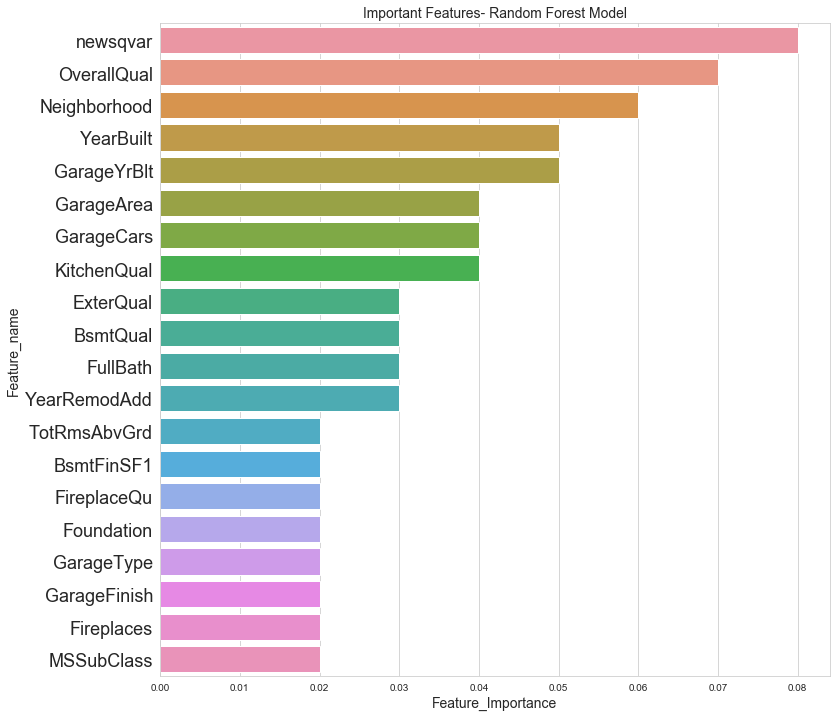

In [43]:
plt.figure(figsize=(12,12))
ax=sns.barplot(x='Feature_Importance',y='Feature_name',data=df.head(20))
ax.set_xlabel('Feature_Importance', fontsize=14)
ax.set_ylabel('Feature_name', fontsize=14)
ax.tick_params(axis="y", labelsize=18)
ax.set_title('Important Features- Random Forest Model', fontsize=14)


## GRADIENT BOOSING REGRESSOR

In [44]:
# Finding the optimum hyperparameters

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor


param_grid={'min_samples_leaf':[2,5,10,15],'n_estimators':[100,200, 500],'min_samples_split':[2,6,8,10,12,15], 'learning_rate':np.linspace(.05,.15,5), 'max_depth': [2,4,6,8,10,12,15], 'max_features':[5,10,15] }    
mean_sq_err=make_scorer(mean_squared_error)

gb_cv=RandomizedSearchCV(GradientBoostingRegressor(),param_grid,scoring=mean_sq_err, cv=5, random_state=3 )
gb_cv.fit(X_train_netrf,y_train_netrf)

print(' Optimum values of hyperparameters for Gradient Boosting model are: ' , gb_cv.best_params_)
print('The cross validated score for Gradient Boosting model on train set is', np.sqrt(gb_cv.best_score_).round(3))

 Optimum values of hyperparameters for Gradient Boosting model are:  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 5, 'max_depth': 2, 'learning_rate': 0.1}
The cross validated score for Gradient Boosting model on train set is 0.114


In [45]:
# Create and fit Gradient Boosting Regressor with optimum hyperparameters
gb=GradientBoostingRegressor(n_estimators= 100, min_samples_split= 10, min_samples_leaf=10, max_depth= 2, learning_rate= 0.1, max_features=5, random_state=3)
gb.fit(X_train_netrf, y_train_netrf)
prediction=gb.predict(X_train_netrf)
print('The RMSE for Gradient Boosting model on train set is :  ', round(np.sqrt(mean_squared_error(y_train_netrf, prediction)),3))
prediction=gb.predict(X_test_netrf)
print('The RMSE for Gradient Boosting model on test set is :  ', round(np.sqrt(mean_squared_error(y_test_netrf, prediction)),3))


The RMSE for Gradient Boosting model on train set is :   0.099
The RMSE for Gradient Boosting model on test set is :   0.084
